---
title: Lab 6 
author: Marvin (Wenxiang) Li
format:
    html:
        toc: true
        code-fold: true
embed-resources: true
---

In [51]:
import numpy as np
import pandas as pd
baseball = pd.read_csv("https://www.dropbox.com/s/boshaqfgdjiaxh4/Hitters.csv?dl=1")
baseball = baseball.dropna().reset_index(drop=True)

In [52]:
baseball.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 263 entries, 0 to 262
Data columns (total 20 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   AtBat      263 non-null    int64  
 1   Hits       263 non-null    int64  
 2   HmRun      263 non-null    int64  
 3   Runs       263 non-null    int64  
 4   RBI        263 non-null    int64  
 5   Walks      263 non-null    int64  
 6   Years      263 non-null    int64  
 7   CAtBat     263 non-null    int64  
 8   CHits      263 non-null    int64  
 9   CHmRun     263 non-null    int64  
 10  CRuns      263 non-null    int64  
 11  CRBI       263 non-null    int64  
 12  CWalks     263 non-null    int64  
 13  League     263 non-null    object 
 14  Division   263 non-null    object 
 15  PutOuts    263 non-null    int64  
 16  Assists    263 non-null    int64  
 17  Errors     263 non-null    int64  
 18  Salary     263 non-null    float64
 19  NewLeague  263 non-null    object 
dtypes: float64

## Part I: Different Model Specs

In [53]:
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures, FunctionTransformer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error

In [54]:
import plotnine as p9

In [55]:
from sklearn.model_selection import GridSearchCV

### A. Regression without regulation

In [56]:
X = baseball.drop(["Salary"], axis = 1)
y = baseball["Salary"]

#### 1. create a pipeline includes all the columns as predictors

In [57]:
ct = ColumnTransformer(
  [
    ("dummify",
    OneHotEncoder(drop='first', sparse_output = False, handle_unknown='ignore'),
    make_column_selector(dtype_include=object)),
    ("standardize",
    StandardScaler(),
    make_column_selector(dtype_include=np.number))
  ],
  remainder = "passthrough"
)

model_1 = Pipeline(
  [("preprocessing", ct),
  ("linear_regression", LinearRegression())]
)

#### 2. Fit this pipeline to the full dataset, and interpret a few of the most important coefficients.

In [58]:
model_1_fitted = model_1.fit(X, y)
coef1 = model_1_fitted.named_steps['linear_regression'].coef_
feature_names = ct.fit(X).get_feature_names_out()  # Assuming X has column names
df_coef = pd.DataFrame({'Feature': feature_names, 'OLS': coef1})
df_coef.sort_values(by = 'OLS', ascending = False)

,Feature,OLS
13,standardize__CRuns,480.747135
4,standardize__Hits,337.830479
14,standardize__CRBI,260.689886
8,standardize__Walks,135.073897
11,standardize__CHits,86.687617
16,standardize__PutOuts,78.761296
0,dummify__League_N,62.599423
17,standardize__Assists,53.732490
5,standardize__HmRun,37.853837
12,standardize__CHmRun,-14.181723


In [59]:
X['CRuns'].std()

331.19857059564885

- for every 331 runs increases in a player's career, there will be a $480740 increase.

In [60]:
X['Hits'].std()

45.12532592258135

- for every 45.12 hits increases in 1986, there will be a $337870 increase.

In [61]:
X['CRBI'].std()

323.3676681827309

- for every 323.36 runs batted increases in a player's career, there will be a $260690 increase.

In [62]:
X['CAtBat'].std()

2286.5829294625905

- for every 2286.58 at batted increases in a player's career, there will be a $391040 decrease.

In [63]:
mse = cross_val_score(model_1, X, y, cv = 5, scoring = 'neg_mean_squared_error')
mse.mean()

-121136.31031816879

#### 4. MSE would be -121136.31

### B. Ridge Regression

#### 1. build a def function for model

In [64]:
def model_try(model):
  ct = ColumnTransformer(
    [
      ("dummify",
      OneHotEncoder(drop='first', sparse_output = False, handle_unknown='ignore'),
      make_column_selector(dtype_include=object)),
      ("standardize",
      StandardScaler(),
      make_column_selector(dtype_include=np.number))
    ],remainder = "passthrough"
    )

  pipeline = Pipeline(
    [("preprocessing", ct),
    ("model", model)] # the only changing part
  )
  return pipeline

#### 2. Gridsearch the best lambda

In [65]:
alpha_range = np.logspace(-3, 1, num=5)
param_grid = {
    'model__alpha': alpha_range,
}

model_2 = model_try(Ridge())
gscv2 = GridSearchCV(model_2, param_grid, cv = 5, scoring='neg_mean_squared_error')
gscv2_fitted = gscv2.fit(X, y)
gscv2_fitted.cv_results_
mse2 = pd.DataFrame(data = {"param_grid":  gscv2_fitted.cv_results_['param_model__alpha'], "scores": gscv2_fitted.cv_results_['mean_test_score']}).sort_values(by = "scores", ascending = False)
mse2


,param_grid,scores
3,1.0,-119034.332720
4,10.0,-119073.956166
2,0.1,-120329.936014
1,0.01,-121021.508944
0,0.001,-121124.318914


#### 3. use lambda 1 to compte coef_

In [66]:
model_2_selected = model_try(Ridge(alpha = 1))
model_2_selected_fitted = model_2_selected.fit(X, y)
coef2 = model_2_selected_fitted.named_steps['model'].coef_
feature_names = ct.fit(X).get_feature_names_out()  # Assuming X has column names
df_coef2 = pd.DataFrame({'Feature': feature_names, 'Ridge': coef2})
df_coef2.sort_values(by = 'Ridge', ascending = False)

,Feature,Ridge
13,standardize__CRuns,320.802717
4,standardize__Hits,296.801967
14,standardize__CRBI,160.409497
11,standardize__CHits,126.210585
8,standardize__Walks,124.344012
16,standardize__PutOuts,78.651037
0,dummify__League_N,58.555947
17,standardize__Assists,47.493631
12,standardize__CHmRun,39.055346
5,standardize__HmRun,17.973971


- for every 331 runs increases in a player's career, there will be a 320.80 increase.
- for every 45.12 hits increases in 1986, there will be a 296.80 increase.
- for every 323.36 runs batted increases in a player's career, there will be a 160.40 increase.

#### 4. MSE would be 119034.332720

### C. Lasso Regression

#### 1. fit a model and tune lambda

In [67]:
alpha_range = np.logspace(-3, 1, num=5)
param_grid = {
    'model__alpha': alpha_range
}
model_3 = model_try(Lasso(max_iter = 100000000))
gscv3 = GridSearchCV(model_3, param_grid, cv = 5, scoring='neg_mean_squared_error')
gscv3_fitted = gscv3.fit(X, y)
gscv3_fitted.cv_results_
mse3 = pd.DataFrame(data = {"param_grid":  gscv3_fitted.cv_results_['param_model__alpha'],
                              "scores": gscv3_fitted.cv_results_['mean_test_score']}).sort_values(by = "scores", ascending = False)
mse3

,param_grid,scores
3,1.0,-119758.108873
2,0.1,-120758.508162
1,0.01,-121096.159270
0,0.001,-121132.276754
4,10.0,-121828.141333


#### 2. Obtian and interpret coeeficients

In [68]:
model_3_selected = model_try(Lasso(alpha = 1, max_iter = 100000000))
model_3_selected_fitted = model_3_selected.fit(X, y)
coef3 = model_3_selected_fitted.named_steps['model'].coef_
feature_names = ct.fit(X).get_feature_names_out()  # Assuming X has column names
df_coef3 = pd.DataFrame({'Feature': feature_names, 'Lasso': coef3})
df_coef3.sort_values(by = 'Lasso', ascending = False)

,Feature,Lasso
13,standardize__CRuns,375.565519
4,standardize__Hits,304.359509
14,standardize__CRBI,192.610892
8,standardize__Walks,120.695275
16,standardize__PutOuts,78.760366
17,standardize__Assists,41.996680
0,dummify__League_N,35.826072
12,standardize__CHmRun,14.225993
5,standardize__HmRun,11.127022
2,dummify__NewLeague_N,-0.000000


- for every 331 runs increases in a player's career, there will be a 375.56 increase.
- for every 45.12 hits increases in 1986, there will be a 304.35 increase.
- for every 323.36 runs batted increases in a player's career, there will be a 192.61 increase.

#### 3. MSE would be-119758.108873

### D. Elastic Net

#### 1. fit a model and tune lambda

In [ ]:
alpha_range = np.logspace(-3, 2, num=6)
l1_ratio_range = np.linspace(0.1, 1, num=10)
param_grid2 = {
    'model__alpha': alpha_range,
    'model__l1_ratio': l1_ratio_range
}
model_4 = model_try(ElasticNet(max_iter = 10000000))
gscv4 = GridSearchCV(model_4, param_grid2, cv = 5, scoring='neg_mean_squared_error')
gscv4_fitted = gscv4.fit(X, y)
gscv4_fitted.cv_results_
mse4 = pd.DataFrame({
    'elastic_alpha': gscv4_fitted.cv_results_['param_model__alpha'],
    'elastic_l1_ratio': gscv4_fitted.cv_results_['param_model__l1_ratio'],
    'scores': gscv4_fitted.cv_results_['mean_test_score']
}).sort_values(by = "scores", ascending = False)
mse4.head()

,elastic_alpha,elastic_l1_ratio,scores
13,0.1,0.775,-118752.856590
5,0.01,0.1,-118802.210703
6,0.01,0.325,-118893.327156
12,0.1,0.55,-119054.255261
7,0.01,0.55,-119054.795881


#### 2. Obtain and interpret coefficients

In [70]:
model_4_selected = model_try(ElasticNet(alpha=0.1, l1_ratio=0.775, max_iter = 1000000))
model_4_selected_fitted = model_4_selected.fit(X, y)
coef4 = model_4_selected_fitted.named_steps['model'].coef_
feature_names = ct.fit(X).get_feature_names_out()  # Assuming X has column names
df_coef4 = pd.DataFrame({'Feature': feature_names, 'Elastic Net': coef4})
df_coef4.sort_values(by = 'Elastic Net', ascending = False)

,Feature,Elastic Net
4,standardize__Hits,191.915457
13,standardize__CRuns,154.853871
11,standardize__CHits,107.827265
14,standardize__CRBI,102.155652
8,standardize__Walks,94.647003
16,standardize__PutOuts,76.676660
12,standardize__CHmRun,59.375268
0,dummify__League_N,44.260380
17,standardize__Assists,33.991693
6,standardize__Runs,12.540359


In [71]:
X['CHits'].std()

648.1996437306398

- for every 45.12 hits increases in 1986, there will be a 191.91 increase.
- for every 331.19 runs increases in a player's career, there will be a 154.85 increase.
- for every 648.19 hits increases in a player's career, there will be a 107.82 increase.

#### 3. MSE would be -118752.856590

## Part II. Variable Selection

- Based on the absoulte values of the coefficients, the most important variable across all 4 models is CRuns
- The five most important numeric variables are CRuns,
Hits, CRBI, CHits, and Walks.
- Division_W is the most important cat variable

### 1. Use only the best variable

In [72]:
X2 = baseball[["CRuns"]]

- Model 1 OLS

In [73]:
model_2_1 = model_try(LinearRegression())
model_2_1_fitted = model_2_1.fit(X2, y)
mse21 = cross_val_score(model_2_1, X2, y, cv = 5, scoring = 'neg_mean_squared_error')
mse21.mean()

-143812.9359162973

In [74]:
coef21 = model_2_1_fitted.named_steps['model'].coef_
feature_names = ct.fit(X2).get_feature_names_out()  # Assuming X has column names
df_coef21 = pd.DataFrame({'Feature': feature_names, 'OLS': coef21})
df_coef21.sort_values(by = 'OLS', ascending = False)

,Feature,OLS
0,standardize__CRuns,253.351392


- Model 2 Ridge

In [75]:
gscv2_2_fitted = gscv2.fit(X2, y)
gscv2_2_fitted.cv_results_
mse22 = pd.DataFrame(data =
 {"param_grid":  gscv2_2_fitted.cv_results_['param_model__alpha'],
  "scores": gscv2_2_fitted.cv_results_['mean_test_score']
  }).sort_values(by = "scores", ascending = False)
mse22

,param_grid,scores
4,10.0,-143658.517369
3,1.0,-143783.706854
2,0.1,-143809.862456
1,0.01,-143812.627051
0,0.001,-143812.905015


In [76]:
model_2_2_selected = model_try(Ridge(alpha = 10))
model_2_2_selected_fitted = model_2_2_selected.fit(X2, y)
coef22 = model_2_2_selected_fitted.named_steps['model'].coef_
feature_names = ct.fit(X2).get_feature_names_out()  # Assuming X has column names
df_coef22 = pd.DataFrame({'Feature': feature_names, 'Ridge': coef22})
df_coef22.sort_values(by = 'Ridge', ascending = False)

,Feature,Ridge
0,standardize__CRuns,244.071121


- Model 3 Lasso

In [77]:
gscv2_3_fitted = gscv3.fit(X2, y)
gscv2_3_fitted.cv_results_
mse23 = pd.DataFrame(data =
 {"param_grid":  gscv2_3_fitted.cv_results_['param_model__alpha'],
  "scores": gscv2_3_fitted.cv_results_['mean_test_score']
  }).sort_values(by = "scores", ascending = False)
mse23

,param_grid,scores
4,10.0,-143793.449159
3,1.0,-143801.606084
2,0.1,-143811.709122
1,0.01,-143812.812299
0,0.001,-143812.923545


- Model 4 Elastic Net

In [78]:
gscv2_4_fitted = gscv4.fit(X2, y)
gscv2_4_fitted.cv_results_
mse24 = pd.DataFrame({
    'elastic_alpha': gscv2_4_fitted.cv_results_['param_model__alpha'],
    'elastic_l1_ratio': gscv2_4_fitted.cv_results_['param_model__l1_ratio'],
    'scores': gscv2_4_fitted.cv_results_['mean_test_score']
}).sort_values(by = "scores", ascending = False)
mse24.head()

,elastic_alpha,elastic_l1_ratio,scores
12,0.1,0.55,-143656.753620
11,0.1,0.325,-143670.690061
13,0.1,0.775,-143701.093907
10,0.1,0.1,-143735.873327
5,0.01,0.1,-143759.624708


### 2. Use only the five important variables

In [79]:
X3 = baseball[['CRuns', 'Hits', 'CRBI', 'CHits', 'Walks']]

- Model 1 OLS

In [80]:
model_3_1 = model_try(LinearRegression())
model_3_1_fitted = model_3_1.fit(X3, y)
mse31 = cross_val_score(model_3_1, X3, y, cv = 5, scoring = 'neg_mean_squared_error')
mse31.mean()

-126047.77085146765

In [81]:
coef31 = model_3_1_fitted.named_steps['model'].coef_
feature_names = ct.fit(X3).get_feature_names_out()  # Assuming X has column names
df_coef31 = pd.DataFrame({'Feature': feature_names, 'OLS': coef31})
df_coef31.sort_values(by = 'OLS', ascending = False)

,Feature,OLS
2,standardize__CRBI,162.874117
1,standardize__Hits,112.191438
0,standardize__CRuns,91.951326
4,standardize__Walks,63.583665
3,standardize__CHits,-41.237667


- Model 2 Ridge

In [82]:
gscv3_2_fitted = gscv2.fit(X3, y)
gscv3_2_fitted.cv_results_
mse32 = pd.DataFrame(data =
 {"param_grid":  gscv3_2_fitted.cv_results_['param_model__alpha'],
  "scores": gscv3_2_fitted.cv_results_['mean_test_score']
  }).sort_values(by = "scores", ascending = False)
mse32

,param_grid,scores
4,10.0,-123172.832275
3,1.0,-125269.250471
2,0.1,-125949.562233
1,0.01,-126037.669848
0,0.001,-126046.757841


In [83]:
model_3_2_selected = model_try(Ridge(alpha = 10))
model_3_2_selected_fitted = model_3_2_selected.fit(X3, y)
coef32 = model_3_2_selected_fitted.named_steps['model'].coef_
feature_names = ct.fit(X3).get_feature_names_out()  # Assuming X has column names
df_coef32 = pd.DataFrame({'Feature': feature_names, 'Ridge': coef32})
df_coef32.sort_values(by = 'Ridge', ascending = False)

,Feature,Ridge
2,standardize__CRBI,126.472957
1,standardize__Hits,104.861189
4,standardize__Walks,69.846563
0,standardize__CRuns,57.286936
3,standardize__CHits,26.383317


- Model 3 Lasso

In [84]:
gscv3_3_fitted = gscv3.fit(X3, y)
gscv3_3_fitted.cv_results_
mse33 = pd.DataFrame(data =
 {"param_grid":  gscv3_3_fitted.cv_results_['param_model__alpha'],
  "scores": gscv3_3_fitted.cv_results_['mean_test_score']
  }).sort_values(by = "scores", ascending = False)
mse33

,param_grid,scores
4,10.0,-124607.123928
3,1.0,-125054.402877
2,0.1,-125915.133673
1,0.01,-126036.097664
0,0.001,-126046.612418


- Model 4 Elastic Net

In [85]:
gscv3_4_fitted = gscv4.fit(X3, y)
gscv3_4_fitted.cv_results_
mse34 = pd.DataFrame({
    'elastic_alpha': gscv3_4_fitted.cv_results_['param_model__alpha'],
    'elastic_l1_ratio': gscv3_4_fitted.cv_results_['param_model__l1_ratio'],
    'scores': gscv3_4_fitted.cv_results_['mean_test_score']
}).sort_values(by = "scores", ascending = False)
mse34.head()

,elastic_alpha,elastic_l1_ratio,scores
18,1.0,0.775,-122089.248214
17,1.0,0.55,-122440.117631
10,0.1,0.1,-122588.577519
11,0.1,0.325,-122837.367932
12,0.1,0.55,-123223.674716


### 3. Use five variables and interaction with the most important dummy

In [86]:
X4 = baseball[['CRuns', 'Hits', 'CRBI', 'CHits', 'Walks', 'Division']]

In [87]:
def model_try2(model):
  ct = ColumnTransformer(
    [
      ("dummify",
      OneHotEncoder(drop='first', sparse_output = False, handle_unknown='ignore'),
      make_column_selector(dtype_include=object)),
      ("standardize",
      StandardScaler(),
      make_column_selector(dtype_include=np.number))
    ],remainder = "passthrough"
    ).set_output(transform="pandas")
  ct2 = ColumnTransformer(
    [
        ('interaction1', PolynomialFeatures(interaction_only=True, include_bias=False), ['standardize__CRuns', 'dummify__Division_W']),
        ('interaction2', PolynomialFeatures(interaction_only=True, include_bias=False), ['standardize__Hits', 'dummify__Division_W']),
        ('interaction3', PolynomialFeatures(interaction_only=True, include_bias=False), ['standardize__CRBI', 'dummify__Division_W']),
        ('interaction4', PolynomialFeatures(interaction_only=True, include_bias=False), ['standardize__CHits', 'dummify__Division_W']),
        ('interaction5', PolynomialFeatures(interaction_only=True, include_bias=False), ['standardize__Walks', 'dummify__Division_W'])
    ],
    remainder= "drop"
    ).set_output(transform="pandas")

  pipeline = Pipeline(
    [("preprocessing", ct),
     ("interaction", ct2),
     ("model", model)] # the only changing part
    )
  return pipeline

- Model 1 OLS

In [88]:
model_4_1 = model_try2(LinearRegression())
model_4_1_fitted = model_4_1.fit(X4, y)
mse41 = cross_val_score(model_4_1, X4, y, cv = 5, scoring = 'neg_mean_squared_error')
mse41.mean()

-134896.04426742907

In [89]:
feature_name41 = model_4_1.named_steps['interaction'].get_feature_names_out()
coef41 = model_4_1_fitted.named_steps['model'].coef_

df_coef41 = pd.DataFrame({
    "feature": feature_name41, "OLS": coef41})
df_coef41 = df_coef41.sort_values(by="OLS", ascending=False)
df_coef41

,feature,OLS
11,interaction4__standardize__CHits dummify__Divi...,372.090166
6,interaction3__standardize__CRBI,315.889028
3,interaction2__standardize__Hits,112.136085
12,interaction5__standardize__Walks,82.046526
0,interaction1__standardize__CRuns,69.574498
5,interaction2__standardize__Hits dummify__Divis...,-27.691808
4,interaction2__dummify__Division_W,-27.909572
10,interaction4__dummify__Division_W,-27.909572
13,interaction5__dummify__Division_W,-27.909572
7,interaction3__dummify__Division_W,-27.909572


- Model 2 Ridge

In [90]:
model_4_2 = model_try2(Ridge())
gscv4_2 = GridSearchCV(model_4_2, param_grid, cv = 5, scoring='neg_mean_squared_error')
gscv4_2_fitted = gscv4_2.fit(X4, y)
gscv4_2_fitted.cv_results_
mse42 = pd.DataFrame(data =
 {"param_grid":  gscv4_2_fitted.cv_results_['param_model__alpha'],
  "scores": gscv4_2_fitted.cv_results_['mean_test_score']
  }).sort_values(by = "scores", ascending = False)
mse42

,param_grid,scores
4,10.0,-120167.252960
3,1.0,-126996.127537
2,0.1,-133141.977056
1,0.01,-134691.592069
0,0.001,-134875.244943


In [91]:
model_4_2_selected = model_try2(Ridge(alpha=10))
model_4_2_selected_fitted = model_4_2_selected.fit(X4, y)

feature_name42 = model_4_2_selected.named_steps['interaction'].get_feature_names_out()
coef42 = model_4_2_selected_fitted.named_steps['model'].coef_

df_coef42 = pd.DataFrame({
    "feature": feature_name42, "Ridge": coef42})
df_coef42 = df_coef42.sort_values(by="Ridge", ascending=False)
df_coef42

,feature,Ridge
6,interaction3__standardize__CRBI,157.459941
3,interaction2__standardize__Hits,100.259869
12,interaction5__standardize__Walks,89.552809
9,interaction4__standardize__CHits,57.994893
0,interaction1__standardize__CRuns,38.253567
11,interaction4__standardize__CHits dummify__Divi...,15.235975
5,interaction2__standardize__Hits dummify__Divis...,-9.930896
13,interaction5__dummify__Division_W,-26.633144
10,interaction4__dummify__Division_W,-26.633144
7,interaction3__dummify__Division_W,-26.633144


- Model 3 Lasso

In [92]:
model_4_3 = model_try2(Lasso(max_iter = 1000000))
gscv4_3 = GridSearchCV(model_4_3, param_grid, cv = 5, scoring='neg_mean_squared_error')
gscv4_3_fitted = gscv4_3.fit(X4, y)
gscv4_3_fitted.cv_results_
mse43 = pd.DataFrame(data =
 {"param_grid":  gscv4_3_fitted.cv_results_['param_model__alpha'],
  "scores": gscv4_3_fitted.cv_results_['mean_test_score']
  }).sort_values(by = "scores", ascending = False)
mse43

,param_grid,scores
4,10.0,-121683.328737
3,1.0,-127988.983194
2,0.1,-133883.172855
1,0.01,-134792.864612
0,0.001,-134885.971588


- Model 4 Elastic Net

In [93]:
model_4_4 = model_try2(ElasticNet(max_iter = 1000000))
gscv4_4 = GridSearchCV(model_4_4, param_grid2, cv = 5, scoring='neg_mean_squared_error')
gscv4_4_fitted = gscv4_4.fit(X4, y)
gscv4_4_fitted.cv_results_
mse44 = pd.DataFrame({
    'elastic_alpha': gscv4_4_fitted.cv_results_['param_model__alpha'],
    'elastic_l1_ratio': gscv4_4_fitted.cv_results_['param_model__l1_ratio'],
    'scores': gscv4_4_fitted.cv_results_['mean_test_score']
}).sort_values(by = "scores", ascending = False)
mse44.head()

,elastic_alpha,elastic_l1_ratio,scores
18,1.0,0.775,-117726.929165
17,1.0,0.55,-118757.391139
10,0.1,0.1,-118763.994627
11,0.1,0.325,-119350.126418
12,0.1,0.55,-120277.023531


## Part III. Discussion

### A. Ridge

In [94]:
a1 = df_coef.merge(df_coef2, on = 'Feature', how = 'left')
a1

,Feature,OLS,Ridge
0,dummify__League_N,62.599423,58.555947
1,dummify__Division_W,-116.849246,-119.076927
2,dummify__NewLeague_N,-24.762325,-24.027205
3,standardize__AtBat,-291.094556,-271.088165
4,standardize__Hits,337.830479,296.801967
5,standardize__HmRun,37.853837,17.973971
6,standardize__Runs,-60.572479,-29.212352
7,standardize__RBI,-26.994984,-8.909304
8,standardize__Walks,135.073897,124.344012
9,standardize__Years,-16.693359,-38.619131


In [95]:
a2 = df_coef21.merge(df_coef22, on = 'Feature', how = 'left')
a2

,Feature,OLS,Ridge
0,standardize__CRuns,253.351392,244.071121


In [96]:
a3 = df_coef31.merge(df_coef32, on = 'Feature', how = 'left')
a3

,Feature,OLS,Ridge
0,standardize__CRuns,91.951326,57.286936
1,standardize__Hits,112.191438,104.861189
2,standardize__CRBI,162.874117,126.472957
3,standardize__CHits,-41.237667,26.383317
4,standardize__Walks,63.583665,69.846563


In [97]:
a4 = df_coef41.merge(df_coef42, on = 'feature', how = 'left')
a4

,feature,OLS,Ridge
0,interaction4__standardize__CHits dummify__Divi...,372.090166,15.235975
1,interaction3__standardize__CRBI,315.889028,157.459941
2,interaction2__standardize__Hits,112.136085,100.259869
3,interaction5__standardize__Walks,82.046526,89.552809
4,interaction1__standardize__CRuns,69.574498,38.253567
5,interaction2__standardize__Hits dummify__Divis...,-27.691808,-9.930896
6,interaction2__dummify__Division_W,-27.909572,-26.633144
7,interaction4__dummify__Division_W,-27.909572,-26.633144
8,interaction5__dummify__Division_W,-27.909572,-26.633144
9,interaction3__dummify__Division_W,-27.909572,-26.633144


- the above comparisons show that coefficients produced by Ridge models are smaller. It is due to the bias added to the model to make it less flexible.

### B. LASSO

In [98]:
mse3

,param_grid,scores
3,1.0,-119758.108873
2,0.1,-120758.508162
1,0.01,-121096.159270
0,0.001,-121132.276754
4,10.0,-121828.141333


In [99]:
b1 = mse23.merge(mse33, on = 'param_grid')
b2 = b1.merge(mse43, on = 'param_grid')
b2.columns = ['param_grid', 'mse23_score', 'mse33_score', 'mse43_score']
b2

,param_grid,mse23_score,mse33_score,mse43_score
0,10.0,-143793.449159,-124607.123928,-121683.328737
1,1.0,-143801.606084,-125054.402877,-127988.983194
2,0.1,-143811.709122,-125915.133673,-133883.172855
3,0.01,-143812.812299,-126036.097664,-134792.864612
4,0.001,-143812.923545,-126046.612418,-134885.971588


- Lasso model in I results in lambda 1, while models in II result in lambda 10.
- The model in I result in a smaller lambda because it has 19 variables, so the penalty term is big enough with a smaller lambda.
- Models in II has less variables so that a bigger lambda is needed for the penalty term to be effective.

### C. Elastic Net

- Part I

- Result MSEs of Elastic Net is listed as first

In [100]:
print(
    mse4['mean_test_score'].max(),
mse3['scores'].max(),
mse2['scores'].max(),
mse.mean()
)

KeyError: 'mean_test_score'

- Part II 1

In [ ]:
print(
    mse24['mean_test_score'].max(),
mse23['scores'].max(),
mse22['scores'].max(),
mse21.mean()
)

-143656.7536197924 -143793.4491585397 -143658.5173685888 -143812.9359162973


- Part II 2

In [ ]:
print(
    mse34['mean_test_score'].max(),
mse33['scores'].max(),
mse32['scores'].max(),
mse31.mean()
)

-122089.24821369346 -124607.12392785048 -123172.83227523179 -126047.77085146765


- Part II 3

In [ ]:
print(
    mse44['mean_test_score'].max(),
mse43['scores'].max(),
mse42['scores'].max(),
mse41.mean()
)

-117726.92916476393 -121683.32873692471 -120167.2529598724 -134896.04426742913


- The Elastic Net models indeed have the lowest mse in all evaluations.
- It always wins because it the lasso regularizaton helps eleminate uncorrelated variables while the ridge component helps reduce overfitting.

## Part IV: Final Model

- fit full dataset using all variable with interaction with division west

In [ ]:
model_4_4_selected = model_try2(ElasticNet(alpha=1, l1_ratio= 0.775, max_iter = 1000000))
model_4_4_selected_fitted = model_4_4_selected.fit(X, y)


feature_name44 = model_4_4_selected.named_steps['interaction'].get_feature_names_out()
coef44 = model_4_4_selected_fitted.named_steps['model'].coef_

df_coef44 = pd.DataFrame({
    "feature": feature_name44, "Coefficient": coef44})
df_coef44 = df_coef44.sort_values(by="Coefficient", ascending=False)
df_coef44

,feature,Coefficient
6,interaction3__standardize__CRBI,95.847900
3,interaction2__standardize__Hits,86.775884
12,interaction5__standardize__Walks,74.363063
9,interaction4__standardize__CHits,64.508326
0,interaction1__standardize__CRuns,63.683523
5,interaction2__standardize__Hits dummify__Divis...,-1.044242
11,interaction4__standardize__CHits dummify__Divi...,-8.567672
2,interaction1__standardize__CRuns dummify__Divi...,-17.975950
8,interaction3__standardize__CRBI dummify__Divis...,-18.900487
14,interaction5__standardize__Walks dummify__Divi...,-22.666381


In [ ]:
mse44_rmse = cross_val_score(model_4_4_selected, X, y, cv = 5, scoring = 'neg_root_mean_squared_error')
mse44_r2 = cross_val_score(model_4_4_selected, X, y, cv = 5, scoring = 'r2')
print(
    mse44_rmse.mean(),
    mse44_r2.mean()
)

-335.2658474558724 0.40400152243344084


In [ ]:
pred = model_4_4_selected_fitted.predict(X)
residuals = y - pred
df_final = pd.DataFrame({'y': y, 'pred': pred, 'residuals': residuals})

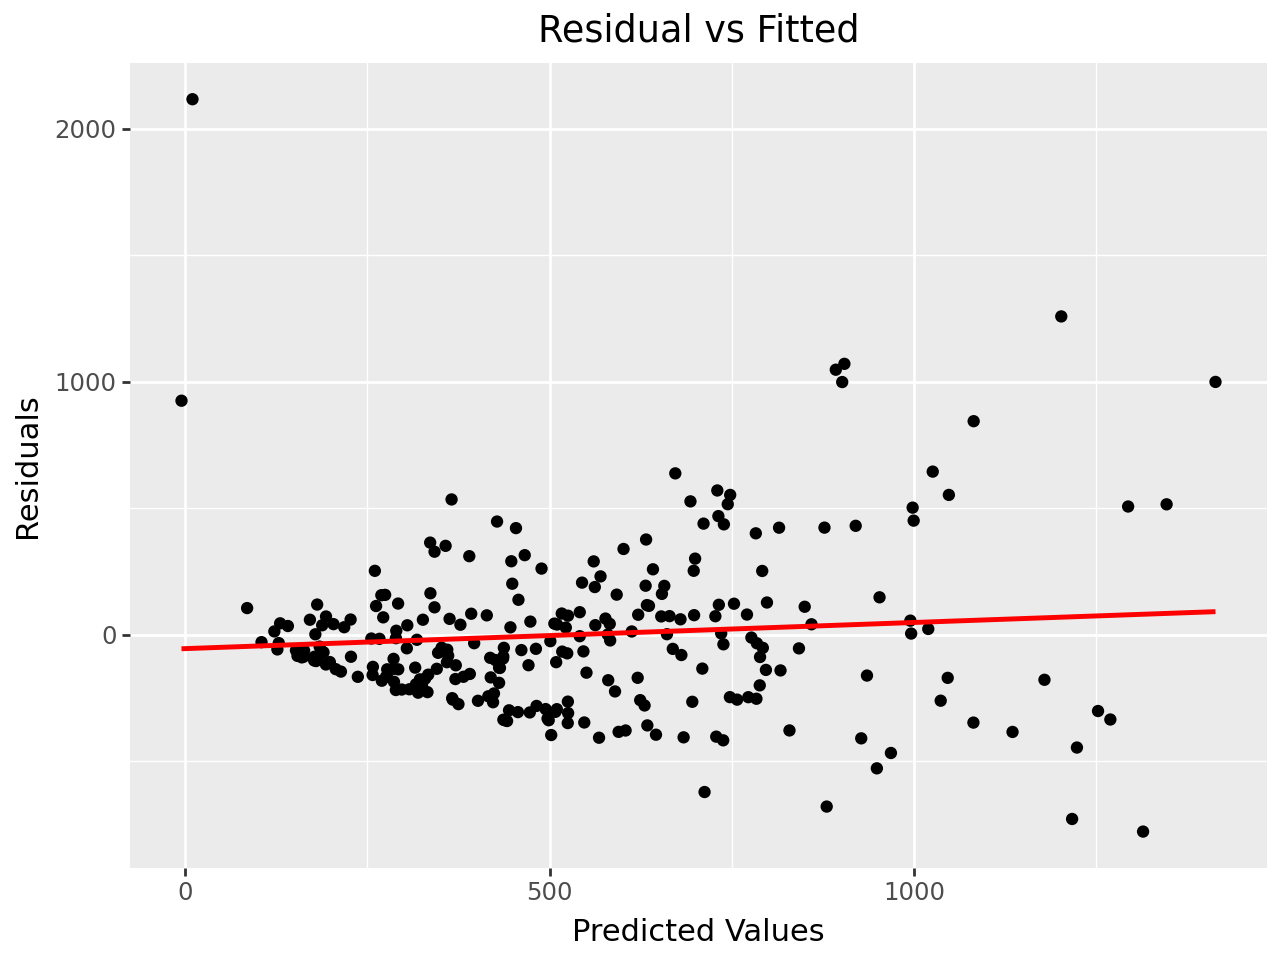

In [ ]:
plot = (p9.ggplot(df_final,p9.aes(x='pred', y='residuals')) +
    p9.geom_point() +
    p9.geom_smooth(method='lm', se=False, color = "red") +
    p9.labs(title='Residual vs Fitted', x='Predicted Values', y='Residuals')
)
plot

- Based on the above results, the best model results in an average RMSE of 335270 dollars. The R2 is 0.404 meaning the model explains about 40% of the data.
- the residual shows heteroscedasticity exsits in this model.